# CTR prediction using ML Models– from scratch

we will build two machine learning models for predicting whether an ad
will be clicked or not. We will use a data set from a Kaggle competition by Avazu – “Click-Through Rate Prediction”.


In [20]:
import numpy as np
import pandas as pd
import seaborn as sns

import dask.dataframe as dask_data
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
from datetime import datetime, date, time

In [21]:
''' Specifying a sample of the original training data 
    Number of records === 40428966 (excess of 40 million records)
    
    Using random sampling to select a sample of 1 million records 
'''
import random
n = 40428966  #total number of records in the clickstream data 
sample_size = 1000000
skip_values = sorted(random.sample(range(1,n), n-sample_size)) 

''' LOADING stage 
    Reading the sampled train data
    Size : 1 million records
'''
train= pd.read_csv('train.csv', skiprows = skip_values )

In [22]:
test= pd.read_csv('test.csv')
test

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000017e+19,14103100,1005,0,235ba823,f6ebf28e,f028772b,ecad2386,7801e8d9,07d7df22,...,1,0,8330,320,50,761,3,175,100075,23
1,1.000018e+19,14103100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,22676,320,50,2616,0,35,100083,51
2,1.000055e+19,14103100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,22676,320,50,2616,0,35,100083,51
3,1.000109e+19,14103100,1005,0,85f751fd,c4e18dd6,50e219e0,51cedd4e,aefc06bd,0f2161f8,...,1,0,18648,320,50,1092,3,809,100156,61
4,1.000138e+19,14103100,1005,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,f95efa07,...,1,0,23160,320,50,2667,0,47,-1,221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4577459,9.998167e+18,14103123,1005,0,93eaba74,7687a86e,3e814130,ecad2386,7801e8d9,07d7df22,...,1,0,17654,300,250,1994,2,39,-1,33
4577460,9.998250e+18,14103123,1005,0,17d1b03f,f3845767,f028772b,ecad2386,7801e8d9,07d7df22,...,1,0,22104,320,50,2545,0,431,100084,221
4577461,9.998802e+16,14103123,1005,0,5b08c53b,7687a86e,3e814130,ecad2386,7801e8d9,07d7df22,...,1,0,17654,300,250,1994,2,39,-1,33
4577462,9.999087e+18,14103123,1005,0,85f751fd,c4e18dd6,50e219e0,92f5800b,ae637522,0f2161f8,...,1,3,23857,320,50,2734,1,175,100189,71


# Exploratory Data Analysis

In [23]:
train.describe()

,id,click,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,1.000001e+06,1.000001e+06,1.000001e+06,1.000001e+06,1.000001e+06,1.000001e+06,1.000001e+06,1.000001e+06,1.000001e+06,1.000001e+06,1.000001e+06,1.000001e+06,1.000001e+06,1.000001e+06,1.000001e+06
mean,9.220798e+18,1.695918e-01,1.410256e+07,1.004969e+03,2.881977e-01,1.015731e+00,3.306207e-01,1.884270e+04,3.188632e+02,6.020658e+01,2.112803e+03,1.433226e+00,2.270182e+02,5.321945e+04,8.349937e+01
std,5.323436e+18,3.752740e-01,2.968688e+02,1.092588e+00,5.069359e-01,5.264784e-01,8.533937e-01,4.960862e+03,2.117370e+01,4.765363e+01,6.095448e+02,1.325933e+00,3.511550e+02,4.995668e+04,7.035966e+01
min,1.441823e+13,0.000000e+00,1.410210e+07,1.001000e+03,0.000000e+00,0.000000e+00,0.000000e+00,3.750000e+02,1.200000e+02,2.000000e+01,1.120000e+02,0.000000e+00,3.300000e+01,-1.000000e+00,1.000000e+00
25%,4.608762e+18,0.000000e+00,1.410230e+07,1.005000e+03,0.000000e+00,1.000000e+00,0.000000e+00,1.692000e+04,3.200000e+02,5.000000e+01,1.863000e+03,0.000000e+00,3.500000e+01,-1.000000e+00,2.300000e+01
50%,9.221913e+18,0.000000e+00,1.410260e+07,1.005000e+03,0.000000e+00,1.000000e+00,0.000000e+00,2.034600e+04,3.200000e+02,5.000000e+01,2.323000e+03,2.000000e+00,3.900000e+01,1.000480e+05,6.100000e+01
75%,1.382972e+19,0.000000e+00,1.410281e+07,1.005000e+03,1.000000e+00,1.000000e+00,0.000000e+00,2.189400e+04,3.200000e+02,5.000000e+01,2.526000e+03,3.000000e+00,1.710000e+02,1.000880e+05,1.020000e+02
max,1.844673e+19,1.000000e+00,1.410302e+07,1.012000e+03,7.000000e+00,5.000000e+00,5.000000e+00,2.404900e+04,1.024000e+03,1.024000e+03,2.758000e+03,3.000000e+00,1.839000e+03,1.002480e+05,2.550000e+02


In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000001 entries, 0 to 1000000
Data columns (total 24 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   id                1000001 non-null  uint64
 1   click             1000001 non-null  int64 
 2   hour              1000001 non-null  int64 
 3   C1                1000001 non-null  int64 
 4   banner_pos        1000001 non-null  int64 
 5   site_id           1000001 non-null  object
 6   site_domain       1000001 non-null  object
 7   site_category     1000001 non-null  object
 8   app_id            1000001 non-null  object
 9   app_domain        1000001 non-null  object
 10  app_category      1000001 non-null  object
 11  device_id         1000001 non-null  object
 12  device_ip         1000001 non-null  object
 13  device_model      1000001 non-null  object
 14  device_type       1000001 non-null  int64 
 15  device_conn_type  1000001 non-null  int64 
 16  C14               

In [25]:
print('Train columns with null values:\n', train.isnull().sum())

Train columns with null values:
 id                  0
click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
dtype: int64


In [29]:
train.nunique()

id                  1000001
click                     2
hour                    240
C1                        7
banner_pos                7
site_id                2626
site_domain            2883
site_category            20
app_id                 3113
app_domain              205
app_category             27
device_id            150070
device_ip            555166
device_model           5186
device_type               5
device_conn_type          4
C14                    2254
C15                       8
C16                       9
C17                     424
C18                       4
C19                      66
C20                     165
C21                      60
dtype: int64

In [26]:
print("Imbalance ratio: {}".format(float(len(train[train['click']==0]))/len(train[train['click']==1])))

Imbalance ratio: 4.896510448606066


###  The ads that were not clicked representing the majority of data instances. (Imblance Data)

In [27]:
train["click"].describe()

count    1.000001e+06
mean     1.695918e-01
std      3.752740e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: click, dtype: float64

0    0.830408
1    0.169592
Name: click, dtype: float64

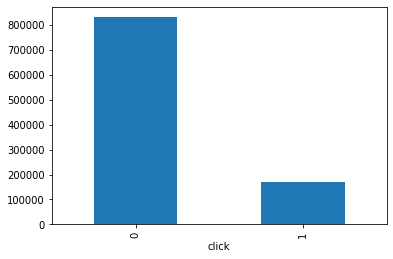

In [28]:
%matplotlib inline

train.groupby('click').size().plot(kind = 'bar')
rows = train.shape[0]

click_through_rate = train['click'].value_counts()/rows 

click_through_rate

### CTR effectively = 16.9%

In [30]:
#NEW METRICS
# datetime column
train['hour']=train['hour'].map(lambda x: datetime.strptime(str(x),"%y%m%d%H"))

train['day_of_week']=train['hour'].map(lambda x:  x.weekday())

train['hour']=train['hour'].map(lambda x:  x.hour)

In [31]:
train.nunique()

id                  1000001
click                     2
hour                     24
C1                        7
banner_pos                7
site_id                2626
site_domain            2883
site_category            20
app_id                 3113
app_domain              205
app_category             27
device_id            150070
device_ip            555166
device_model           5186
device_type               5
device_conn_type          4
C14                    2254
C15                       8
C16                       9
C17                     424
C18                       4
C19                      66
C20                     165
C21                      60
day_of_week               7
dtype: int64

In [32]:
train.hour.describe()

count    1.000001e+06
mean     1.128556e+01
std      5.950409e+00
min      0.000000e+00
25%      7.000000e+00
50%      1.100000e+01
75%      1.600000e+01
max      2.300000e+01
Name: hour, dtype: float64

# Banner Position

In [36]:
train['banner_pos'].unique()

array([1, 0, 2, 7, 5, 4, 3], dtype=int64)

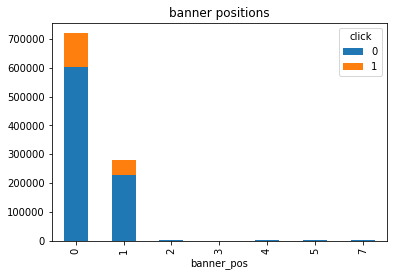

In [37]:
banner_temp =train[['banner_pos','click']].groupby(['banner_pos','click'])
banner_temp.size().unstack().plot(kind='bar',stacked=True, title='banner positions')

### Positions 0 and 1 ~ the most prominent banner positions  and generating most impressions

In [40]:
train_clicks = train[train['click']==1]
train_clicks[['banner_pos','click']].groupby(['banner_pos']).count().sort_values('click',ascending=False)

,click
banner_pos,
0,117999
1,51163
7,330
4,39
2,34
5,16
3,11


In [41]:
banner_df = pd.DataFrame()
banner_df['position'] = train_clicks[['banner_pos','click']].groupby(['banner_pos']).count().reset_index().sort_values('click',ascending=False)['banner_pos']
banner_df['pos_clicks'] = train_clicks[['banner_pos','click']].groupby(['banner_pos']).count().reset_index().sort_values('click',ascending=False)['click']
banner_df['total_impressions'] = train[['banner_pos','click']].groupby(['banner_pos']).count().reset_index().sort_values('click',ascending=False)['click']
banner_df['click_pct'] = 100*banner_df['pos_clicks']/banner_df['total_impressions']
banner_df.sort_values(ascending=False,by='click_pct')


,position,pos_clicks,total_impressions,click_pct
6,7,330,1090,30.275229
4,4,39,188,20.744681
3,3,11,58,18.965517
1,1,51163,278267,18.386298
0,0,117999,719919,16.390594
5,5,16,139,11.510791
2,2,34,340,10.000000


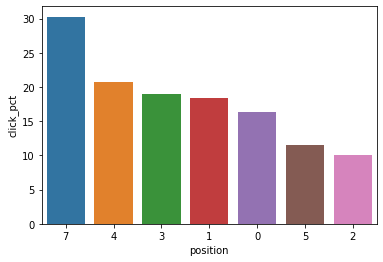

In [42]:
list_of_banners = banner_df.sort_values(by='click_pct',ascending=False)['position'].tolist()
sns.barplot(y='click_pct',x='position',data=banner_df,order=list_of_banners)

#### Banner position 7 seems to be a nice choice for placing advertisements. As per click through rate.

### Analyzing the feature device_type

In [43]:
train["device_type"].value_counts()

1    923333
0     54366
4     19108
5      3193
2         1
Name: device_type, dtype: int64

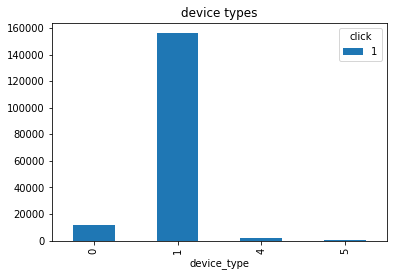

In [46]:
train_clicks[['device_type','click']].groupby(['device_type','click']).size().unstack().plot(kind='bar',stacked=True, title='device types')

In [45]:
train_clicks[['device_type','click']].groupby(['device_type']).count().sort_values('click',ascending=False)

,click
device_type,
1,156026
0,11464
4,1801
5,301


### Device Type 1 gets the maximum number of impressions and clicks 

In [47]:
dev_type_df_total_imp = train.groupby('device_type').agg({'click':'count'})
dev_type_df = train_clicks.groupby('device_type').agg({'click':'count'})
dev_type_df['total_impressions'] = dev_type_df_total_imp['click']
dev_type_df['click_pct'] = (dev_type_df['click']/dev_type_df['total_impressions'])*100
dev_type_df

,click,total_impressions,click_pct
device_type,,,
0,11464,54366,21.086709
1,156026,923333,16.898129
4,1801,19108,9.425372
5,301,3193,9.426871


### Device Type 0 with the highest click through rate

# Device Connection

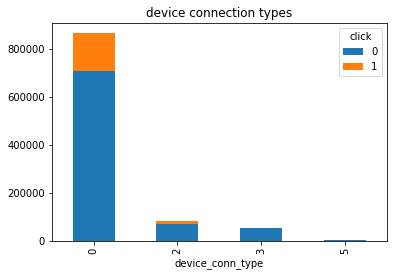

In [49]:
device_conn_temp = train[['device_conn_type','click']].groupby(['device_conn_type','click'])
device_conn_temp.size().unstack().plot(kind='bar',stacked=True, title='device connection types')

In [50]:
dev_conn_type_df_total_imp = train.groupby('device_conn_type').agg({'click':'count'})
dev_conn_type_df = train_clicks.groupby('device_conn_type').agg({'click':'count'})
dev_conn_type_df['total_impressions'] = dev_conn_type_df_total_imp['click']
dev_conn_type_df['click_pct'] = (dev_conn_type_df['click']/dev_conn_type_df['total_impressions'])*100
dev_conn_type_df

,click,total_impressions,click_pct
device_conn_type,,,
0,156008,863089,18.075540
2,11179,82101,13.616156
3,2371,53818,4.405589
5,34,993,3.423968


### App Related Metric Analysis
(App_Id, App_Domain, App_Category)

In [51]:
train['app_category'].value_counts()

07d7df22    647196
0f2161f8    236827
cef3e649     42607
8ded1f7a     36351
f95efa07     28107
d1327cf5      3038
dc97ec06      1374
09481d60      1314
75d80bbe      1002
fc6fa53d       587
4ce2e9fc       499
879c24eb       338
a3c42688       263
4681bb9d       153
0f9a328c       135
a86a3e89        60
2281a340        52
8df2e842        43
79f0b860        16
a7fd01ec        11
0bfbc358         8
7113d72a         7
2fc4f2aa         6
5326cf99         3
18b1e0be         2
4b7ade46         1
86c1a5a3         1
Name: app_category, dtype: int64

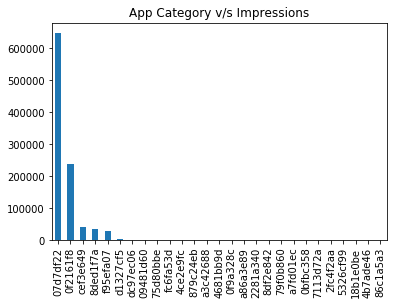

In [54]:
train['app_category'].value_counts().plot(kind='bar', title='App Category v/s Impressions')

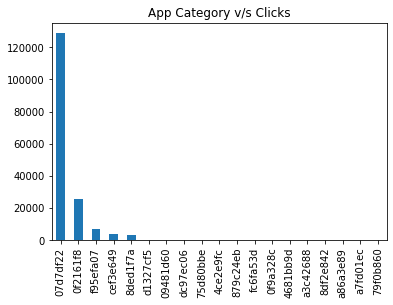

In [55]:
train_clicks['app_category'].value_counts().plot(kind='bar', title='App Category v/s Clicks')

In [56]:
app_cat_df_total_imp = train.groupby('app_category').agg({'click':'count'})
app_cat_df = train_clicks.groupby('app_category').agg({'click':'count'})
app_cat_df['total_impressions'] = app_cat_df_total_imp['click']
app_cat_df['click_pct'] = (app_cat_df['click']/app_cat_df['total_impressions'])*100
app_cat_df.sort_values('click_pct',ascending=False)

,click,total_impressions,click_pct
app_category,,,
a7fd01ec,4,11,36.363636
f95efa07,6981,28107,24.837229
8df2e842,9,43,20.930233
0f9a328c,27,135,20.000000
07d7df22,128666,647196,19.880531
09481d60,212,1314,16.133942
dc97ec06,208,1374,15.138282
4ce2e9fc,74,499,14.829659
d1327cf5,386,3038,12.705727


### Site Related Metric Analysis
(site_id, site_domain, site_category)

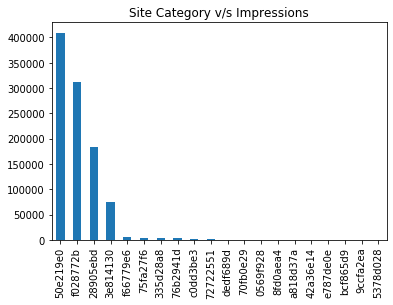

In [57]:
train_data['site_category'].value_counts().plot(kind='bar', title='Site Category v/s Impressions')

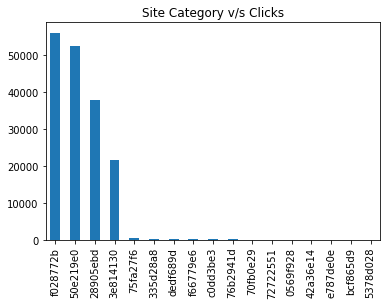

In [58]:
train_clicks['site_category'].value_counts().plot(kind='bar', title='Site Category v/s Clicks')

In [59]:
site_cat_df_total_imp = train.groupby('site_category').agg({'click':'count'})
site_cat_df = train_clicks.groupby('site_category').agg({'click':'count'})
site_cat_df['total_impressions'] = site_cat_df_total_imp['click']
site_cat_df['click_pct'] = (site_cat_df['click']/site_cat_df['total_impressions'])*100
site_cat_df.sort_values('click_pct',ascending=False)

,click,total_impressions,click_pct
site_category,,,
dedf689d,326,627,51.993620
3e814130,21578,75676,28.513664
28905ebd,37742,182621,20.666846
42a36e14,14,73,19.178082
f028772b,56071,313213,17.901875
5378d028,1,7,14.285714
70fb0e29,79,566,13.957597
50e219e0,52481,408493,12.847466
75fa27f6,440,3946,11.150532


# C1, C14-C21 features

In [61]:
features = ['C1', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']

train_data[features].astype('object').describe()

,C1,C14,C15,C16,C17,C18,C19,C20,C21
count,1000001,1000001,1000001,1000001,1000001,1000001,1000001,1000001,1000001
unique,7,2240,8,9,422,4,66,163,60
top,1005,4687,320,50,1722,0,35,-1,23
freq,918286,23549,932807,943437,111307,419196,300998,468083,219602


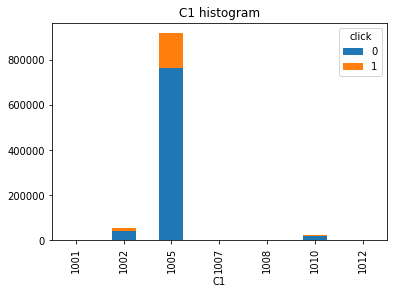

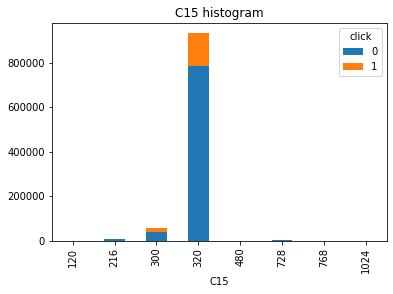

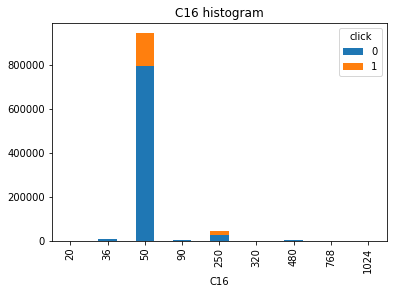

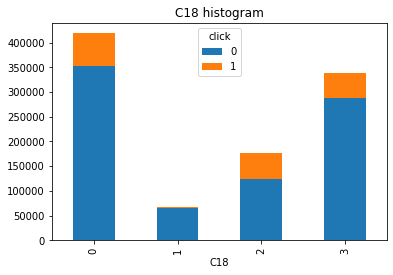

In [62]:
train.groupby(['C1', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C1 histogram')
train.groupby(['C15', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C15 histogram')
train.groupby(['C16', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C16 histogram')
train.groupby(['C18', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C18 histogram')

# Model Selection

In [67]:
cols= ['click', 'hour', 'C1', 'banner_pos', 'site_category', 'app_category', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'day_of_week']
train[cols].head()

,click,hour,C1,banner_pos,site_category,app_category,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,day_of_week
0,0,0,1005,1,f028772b,07d7df22,1,0,20632,320,50,2374,3,39,-1,23,1
1,1,0,1005,0,50e219e0,75d80bbe,1,2,18993,320,50,2161,0,35,100131,157,1
2,1,0,1005,0,28905ebd,07d7df22,1,0,15701,320,50,1722,0,35,100084,79,1
3,0,0,1005,0,f028772b,07d7df22,1,0,16859,320,50,1887,3,39,-1,23,1
4,0,0,1010,1,50e219e0,0f2161f8,4,0,21665,320,50,2493,3,35,-1,117,1


In [68]:
def one_hot_features(data_frame, feature_set):
    new_data_frame = pd.get_dummies(data_frame,
                                     columns = feature_set,
                                    sparse = True)

    return new_data_frame
train_model = one_hot_features(train[cols],
                                ['site_category',
                                 'app_category',
                                 'banner_pos'])

In [70]:
train_model

,click,hour,C1,device_type,device_conn_type,C14,C15,C16,C17,C18,...,app_category_dc97ec06,app_category_f95efa07,app_category_fc6fa53d,banner_pos_0,banner_pos_1,banner_pos_2,banner_pos_3,banner_pos_4,banner_pos_5,banner_pos_7
0,0,0,1005,1,0,20632,320,50,2374,3,...,0,0,0,0,1,0,0,0,0,0
1,1,0,1005,1,2,18993,320,50,2161,0,...,0,0,0,1,0,0,0,0,0,0
2,1,0,1005,1,0,15701,320,50,1722,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,1005,1,0,16859,320,50,1887,3,...,0,0,0,1,0,0,0,0,0,0
4,0,0,1010,4,0,21665,320,50,2493,3,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999996,1,23,1005,1,2,22261,320,50,2545,0,...,0,0,0,1,0,0,0,0,0,0
999997,0,23,1005,1,0,22676,320,50,2616,0,...,0,0,0,1,0,0,0,0,0,0
999998,0,23,1005,1,0,16859,320,50,1887,3,...,0,0,0,1,0,0,0,0,0,0
999999,1,23,1005,1,0,16859,320,50,1887,3,...,0,0,0,1,0,0,0,0,0,0


In [71]:
#Separate target and feature variables
X = train_model.drop('click', axis=1)
Y= train_model['click']

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.25,random_state=42)

In [72]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(750000, 67)
(250001, 67)
(750000,)
(250001,)


In [73]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix

In [74]:
model= DecisionTreeClassifier()
model.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [76]:
y_predict = model.predict(X_test)
accuracy_score(Y_test, y_predict)

0.8076647693409227

In [78]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import xgboost



ModuleNotFoundError: No module named 'xgboost'